#### Building blocks of diffusers
The diffusers are divided into the mainly 3 components:
1) Pipelines: Pipelines are pre-trained models, and It's useful for generating samples from the trained models.
2) Models: In the context of diffusers, models are for training new diffusers models. The popular choice for this is UNet.
3) Schedulers: Schedulers are for generating the images from the noise added to the images during the inference and it can also generate the images from training.

###### Pipelines are great when you are going to just scratch the surface of diffusers. But when are going to deep dive into diffusers you will have to create or generate your own pipelines, which in this notebook I will create basic one.

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/267 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/74.3M [00:00<?, ?B/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

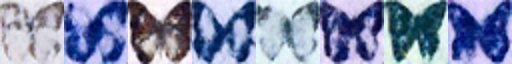

In [3]:
from utils import make_image_grid
import torch
from diffusers import DDPMPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the butterfly datasets from hugging face hub
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

# Create batch size of 8
images = butterfly_pipeline(batch_size=8).images

# View the images
make_image_grid(images)

#### Training the model
Training a diffuser model consists of several steps:
1) Load the selected images from training datasets
2) Add noise to the images with varying amount
3) Add the noisy version of the images to the models, mostly to the UNet model.
4) Evaluate the model denoising effects with the added noise to the images.
5) On the basis of model evaluations, update the model weight and repeat the process.

#### Step 1: Download the training dataset
###### We will download the training dataset from hugging face hub. In below example, I will use the butterflies datasets or we can use our own from a folder if we want. The butterflies datasets consists of collection of 1000 butterflies pictures, a small dataset.

In [6]:
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# We'll train on 32-pixel square images, but you can try larger sizes too
# I will try to train these on 32-pixel size of images to save the GPU for a training on a local system.
image_size = 32

# To save the GPU VRAM we can lower the batch size which is normally 128, I will keep it lower to 64.
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Repo card metadata block was not found. Setting CardData to empty.


###### Get some images from batch and display

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X shape: torch.Size([8, 3, 32, 32])


AttributeError: 'NoneType' object has no attribute 'resize'

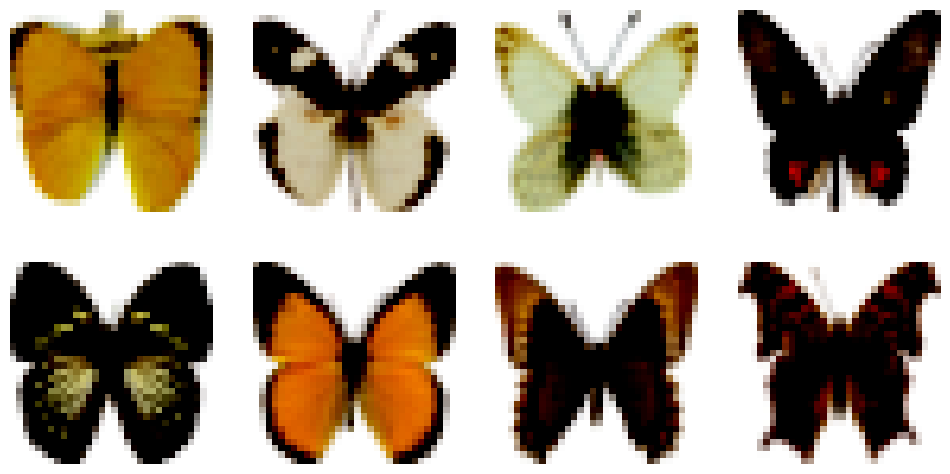

In [15]:
from PIL.Image import Image
from utils import show_images

xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

The above images are small as 32 pixels to keep the training as small as possible for demonstration purpose.

###### Step2: The Scheduler
For training, we will have to get the selected images and then add the noise to it and then feed it into the UNet model.
During the inference, we will use the model evaluation to iteratively remove the noise. Both of these tasks can be handler called Scheduler.
In the below example we will load the DDPMScheduler from diffusers.
The noise scheduler is responsible for the amount of noise to be added to at a different timestamps.
In below example we can provide the default scheduler configuration to DDPM for training and sampling purposes.
DDPM=Denoising diffusions probabilistic models

In [7]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

The paper DDPM describe the addition of noise called corruption. During the corruption process it adds a small amount of noise for every timestamp. Given xt-1, we can get the next slightly noisy version as
${q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})}$


If we take ${x_{t-1}$ and then scale it by ${\sqrt{1 - \beta_t}}$ and then add the noise scaled by ${\beta_t}$. The ${\beta}$ is defined for every timestamp t by some schedule and it determines how much the noise would be added to given image per timestamp. Now we do not have to this operation 500 times to get the timestamp at ${x_{500}}$, we have another formula for it.

\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}

Where ${\bar{\alpha}_t = \prod_{i=1}^T \alpha_i}$ and ${\alpha_i = 1-\beta_i}$

We can plot the above ${\sqrt{\bar{\alpha}_t}}$ and ${\sqrt{(1 - \bar{\alpha}_t)}}$ to show how the input x and the noise scaled and mixed with different timestamp.

In [2]:
from matplotlib import pyplot as plt

plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

NameError: name 'noise_scheduler' is not defined

In [ ]:
# One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
# The 'cosine' schedule, which may be better for small image sizes:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')  

We can now use it to add noise in different amounts using the noise_scheduler.add_noise function like so:

In [14]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

NameError: name 'xb' is not defined

Step 3: Define the Model
For the diffusion models, we will have to use the UNet.

###### In summary:
- The input image has to go through the several blocks of ResNet layers, each of which halves the image size by 2.
- Then it upsimple it through the same number of blocks that downsample it.
- There are skip connections linking the features on the downsample path to the corresponding layers in the upsample path.

The noteable feature of this model is that the predicted image is of the same size as of the added input image, which is indeed the requirement.

The diffusers library provide a function called `UNet2DModel` using the pytorch framework.
There are various options in the UNet which we can finetune for our requirements, such as the size of the image.
The `down_block_types` corresponds to the downsampling while the `up_block_types` corresponds to the upsampling the image.

In [12]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

Looking at the above UNet model, if we want an image of high resolution, we will have to increase the down and up sample blocks and simultaneously  we will have to keep the attention layers as lower as possible.

To check that the input image has the same size as of the output image, we can check it the size of the image from batch at a given timestamp, and it will produce the same size of the image as the input image.

In [13]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

NameError: name 'noisy_xb' is not defined

#### Training the model
To train the model we will have to evaluate the model by providing the different parameters to the model. To get the best optimized model from the batch, we will have to use a loop, where we typically run the data  batch by batch and then updating the parameters of model using an optimizer called `AdamW Optimizer` by providing it a learning rate of 0.0004.

###### The steps for training the a batch of data we will have:
- Sample some random timestamps
- Add noise to the data using scheduler
- Use the added noise data as an input to the UNet model
- Compare the model predictions with the noise, using the mean squared error as a loss function.
- At the end update the model parameters using the back propagation with `loss.backward()` and `optimizer.step()` function.

The below code will take different amount of time depending on the system resources, i.e is its run on GPU (cuda) or CPU.


In [16]:
import torch.nn.functional as F
import torch

# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        print(f"Epoch:{epoch + 1}, loss: {loss_last_epoch}")

/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:5, loss: 0.15459811966866255
Epoch:10, loss: 0.11053866613656282
Epoch:15, loss: 0.09433132596313953
Epoch:20, loss: 0.0825533561874181
Epoch:25, loss: 0.07859765156172216
Epoch:30, loss: 0.06699464283883572


Looking at the above training, one can predict that the model is at great pace at the initial steps, then it getter slowly as shown in the above training loop.
Below we can plot the loss.

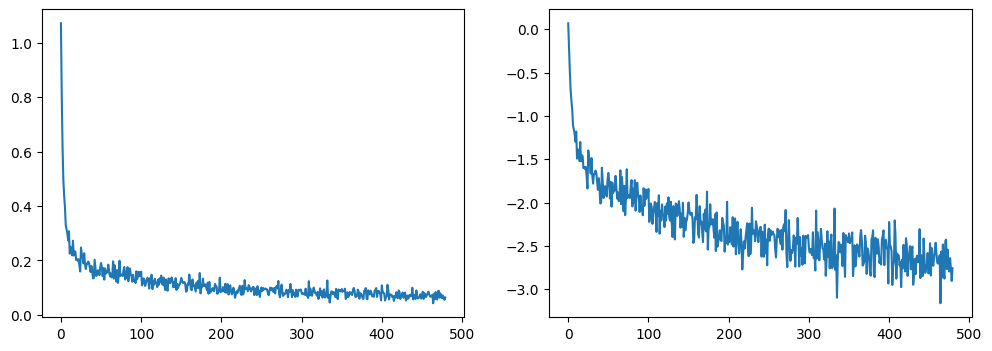

In [17]:
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

###### Step 5: Generate Images
There are two ways through which we can generate images from the trained loop.
1) By Creating a pipeline using the UNet model and noise scheduler as a parameters.
2) By writing a sample loop

1. Using Pipeline

In [18]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

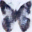

In [19]:
pipeline_output = image_pipe()
pipeline_output.images[0]

Save the pipeline locally which can be used again.

In [20]:
image_pipe.save_pretrained("my_pipeline")

2. By using the Sampling loop 

  With sampling we begin with some random noise and then we have to run it through the scheduler timestamp from most highest to lowest noise, thereby removing a small amount of noise at each successive step based on the model prediction.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


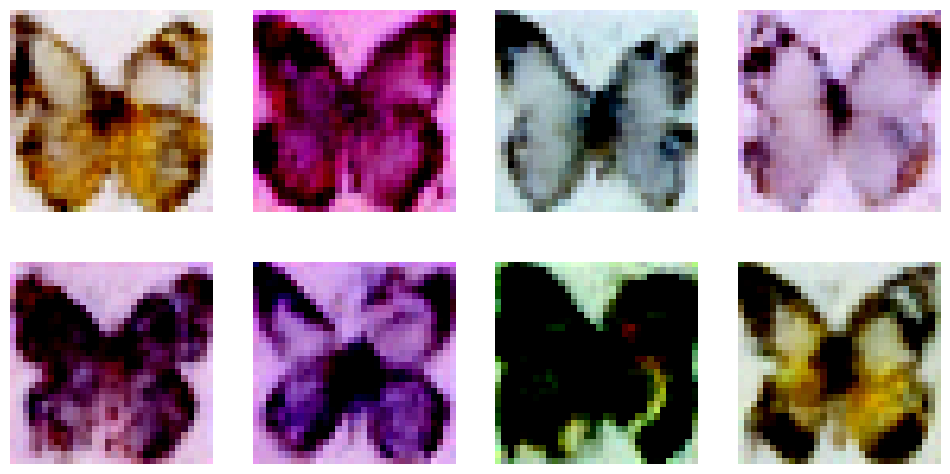

In [21]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):
    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)